In [370]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import iqr, mode
from sklearn.model_selection import train_test_split
from sklearn import tree
import pandas as pd

In [371]:
do_clustering = True
thresh = 90
crop_frac = 0.05

In [372]:
# True positive examples:
# ------------------------------------------
# Works well:
# img_id = '20_nir_2009-07-23'; 
# img_id = '138_nir_2012-06-28'; 
# img_id = '151_nir_2016-06-21'; 
# img_id = '18_nir_2015-08-14';  
# img_id = '194_nir_2013-08-11'; 
# img_id = '322_nir_2013-08-11'
# img_id = '341_nir_2016-07-17'
# img_id = '342_nir_2016-08-03'
# img_id = '343_nir_2016-08-03'
# img_id = '345_nir_2016-08-03'
# img_id = '346_nir_2016-08-09'
# img_id = '347_nir_2016-08-09'
# img_id = '355_nir_2016-08-09'
img_id = '45_nir_2015-08-14'

# Works not as well:
# img_id = '24_nir_2012-07-11'; 
# img_id = '132_nir_2016-09-02'; 
# img_id = '134_nir_2014-07-01'; 
# img_id = '135_nir_2011-08-13'; 
# img_id = '194_nir_2013-08-11'; 
# img_id = '353_nir_2016-08-09'
# img_id = '40_nir_2012-08-21'
# img_id = '55_nir_2010-08-25'

# Doesn't work:
# img_id = '31_nir_2012-06-19'
# img_id = '39_nir_2014-09-06'
# img_id = '16_nir_2016-06-27'



# img_id = '46_nir_2014-07-10'
# img_id  = '229_nir_2014-09-06'
# img_id = '45_nir_2015-08-14'
# img_id = '46_nir_2014-07-10'
# img_id = '73_nir_2013-08-11';  #thresh = 120 # nice lines (not so nice segments)
# img_id = '81_nir_2016-08-03';  #thresh = 80
# img_id = '93_nir_2015-07-24'; #thresh = 90
# img_id = '76_nir_2013-08-11'; #thresh = 80
# img_id = '8_nir_2016-08-09'; #thresh = 80
# img_id = '15_nir_2010-08-14'; #thresh = 70
# img_id = '19_nir_2013-07-28'; #thresh = 80
# img_id = '35_nir_2011-08-03'; #thresh = 90  # bad for prob. hough
# img_id = '77_nir_2013-08-11'; #thresh = 90 # bad for prob. hough

# Ambiquous examples
# ------------------------------------------
# img_id = '11_nir_2015-07-18'
# img_id = '12_nir_2011-07-25'
# img_id = '23_nir_2015-08-14'

# Negative examples
# ------------------------------------------
# img_id = '107_nir_2016-08-23'
# img_id = '125_nir_2016-08-18'

# filein = '../data/fields_nir/' + img_id + '.png'
# filein = '../data/fields_raw/' + img_id + '.png'
filein = '../data/fields_raw_yes_new/' + img_id + '.png'
# filein = '../data/fields_raw_no_new/' + img_id + '.png'


In [373]:
# def extract_features(img,crop_frac,do_clustering):
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

# Crop
length = gray_raw.shape[0]
width = gray_raw.shape[1]
#     frac = 0.05
x1_c = int(crop_frac*length)
x2_c = length - int(crop_frac*length)
y1_c = int(crop_frac*width)
y2_c = width - int(crop_frac*width)

cropped = gray_raw[x1_c:x2_c,y1_c:y2_c]
gray_raw = cropped

# Saturate scale based on percentiles
gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)

edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

# Gaussian blur
blur = cv2.GaussianBlur(gray_sat,(3,3),0)

# Adaptive thresholding on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

# Calculate length of diagonal
diag = np.sqrt(thr_ad_blur.shape[0]**2+thr_ad_blur.shape[1]**2)

# Probabilistic Hough transform (detects line segments)
minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges_ad_thr,1,np.pi/180,50,minLineLength,maxLineGap)
len(lines_pr)

# Get angles and lengths
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)

# feature for detecting if image contains patterns at all: 
# spread in angle in line segments with similar length
thetas_pr_rad = thetas_pr
thetas_pr = np.abs(thetas_pr)

# k-means clustering
if do_clustering:

    feat = np.array([lengths_pr]).T
    kmeans = KMeans(n_clusters=2).fit(feat)
    labels = kmeans.labels_

    # find cluster id that has the max length
    good = labels[lengths_pr==np.max(lengths_pr)][0]
    bad = 1 if good==0 else 0

    ix  = np.where(labels==good)
    ix_bad = np.where(labels==bad)
    cluster_size = len(labels[ix])

    avglength  = np.mean(lengths_pr[ix])/diag
    stdangle  = np.std(thetas_pr[ix])
    medlength =  np.median(lengths_pr[ix])/diag
    iqrangle  = iqr(thetas_pr[ix])

else:
    avglength  = np.mean(lengths_pr)/diag
    stdangle  = np.std(thetas_pr)
    medlength =  np.median(lengths_pr)/diag
    iqrangle  = iqr(thetas_pr)

# return thr_ad_blur, lines_pr, thetas_pr, avglength, stdangle


In [374]:
def detect_patterns(avglength,stdangle):
    class_data = pd.read_csv('labels_round3.txt')
#     class_data = pd.read_csv('labels_cropped.txt')
    class_data = class_data[class_data.ClusterSize>=10]
    class_data = class_data.drop_duplicates(subset=class_data.columns[1:])
    X = np.array([class_data.AvgLength,class_data.StdAngle]).T
    y = class_data.Label.as_matrix()
    N = 1000
    Z = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3) #,random_state=0)

        # Decision tree classification
        clf = tree.DecisionTreeClassifier(min_samples_split=2)
        clf.fit(X_train,y_train)

        # Prediction
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)

        # Decision regions
        Z.append( clf.predict(np.c_[avglength, stdangle])[0] )

    p =  float(len(np.where(np.array(Z)==1)[0]))/len(Z)

    return p
#     if p > 0.5:
#         return True
#     else:
#         return False

In [375]:
# thr_ad_blur, lines_pr, thetas_pr, avglength, stdangle = extract_features(img,crop_frac,do_clustering)

In [376]:
prob = detect_patterns(avglength,stdangle)
print prob

1.0


## Line detection

In [377]:
def plot_lines(lines):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        plt.plot([x1,x2],[y1,y2],'y')

In [378]:
# Plots lines according to their labels. Assumes 2 classes
def plot_lines_lab(lines,labels):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        color = 'g' if labels[line_idx] else 'r'
        plt.plot([x1,x2],[y1,y2],color)

In [379]:
# Function to return centroids of detected lines
def get_centroids(lines):
    XC = np.array([])
    YC = np.array([]);
    
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        xc, yc = (0.5*(x1+x2),0.5*(y1+y2))

        XC = np.append(XC,xc)
        YC = np.append(YC,yc)

    return XC,YC


In [380]:
# Line detection on binary image itself
lines_thr = cv2.HoughLines(thr_ad_blur,0.7,1*np.pi/180,thresh)

In [381]:
# Feature 1: angle 
angles = lines_thr.squeeze()[:,1]#*180./np.pi

# Correct for 2pi cycle (if an angle is close to 2pi, subtract pi)

angle_res = 10*np.pi/180 # angle resolution in degrees
angles = np.where(np.pi - angles < angles,np.pi - angles,angles)

# Feature 2: distance to closest centroid
XC, YC = get_centroids(lines_thr)
centroids = np.array([XC, YC]).T
distances = pdist(centroids,'euclidean')
D = squareform(distances)
D[D==0] = np.nan

dist_clos = np.array([])
for line in range(len(lines_thr)):
    dist_clos = np.append(dist_clos,np.nanmin(D[line,:]))

# Feature 3: number of lines with similar angle

Nsim = np.empty(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    diffs = np.array([])
    for j in range(len(angles)):
        diffs = np.append(diffs,np.abs(angle - angles[j]))

    Nsim[i] = len(diffs[diffs<=angle_res])

features = np.array([angles,np.log10(dist_clos),Nsim]).T

# K-means clustering on the two features angles assuming 2 clusters (true,false)

kmeans = KMeans(n_clusters=2).fit(features)
labels_cl = kmeans.labels_

# Choose based on majority class (assumes minority class is noise)
label_mode = mode(labels_cl)[0][0]
idx_good = np.where(labels_cl==label_mode)[0]

angles = angles[idx_good]
lines = lines_thr[idx_good]
XC = XC[idx_good]
YC = YC[idx_good]

## Describe detected patterns

In [382]:
# Calculate spacing between successive lines that are either horizontal or vertical
def get_spacing(lines,angles):
    XC, YC = get_centroids(lines)
    if (np.abs(np.mean(angles) - 0) <= 5*np.pi/180):
        spacing = np.diff(np.sort(XC))
    elif (np.abs(np.mean(angles) - np.pi/2) <= 5*np.pi/180):
        spacing = np.diff(np.sort(YC))
    else:
        print "lines are neither vertical or horizontal"
    
    return spacing

In [383]:
def get_direction(angles):
    if (np.abs(np.mean(angles - 0)) <= 5*np.pi/180):
        return "ver"
    elif (np.abs(np.mean(angles) - np.pi/2) <= 5*np.pi/180):
        return "hor"
    else:
        return "other"

In [384]:
def cluster_lines(points):
    points = np.sort(points)
    db = DBSCAN(eps=2,min_samples=1).fit(points.reshape(-1,1))
    labels = db.labels_
    df = pd.DataFrame()
    df['labels'] = labels
    df['points'] = points
    df2 = df.groupby('labels').mean()
    points_cl = np.array(df2['points'])
    cycle_px = np.median(np.diff(points_cl))
    cycle_range = iqr(np.diff(points_cl))

    return points_cl, cycle_px, cycle_range

In [385]:
def plot_box(img,direction,points_cl):

    # vertical lines within 5 degrees
    if direction=="ver":
        x0 = np.median(XC); x1 = x0 + cycle_px
        y0 = img.shape[0]/2
        plt.plot([x0,x1],[y0,y0],'r',linewidth=2)
        xl = np.min(XC)+x1_c; xr = np.max(XC)+x1_c
        yt = 0; yb = img.shape[0]
        plt.plot([xl,xr,xr,xl,xl],[0,0,yb,yb,yt],'b',linewidth=2)
        plt.plot(points_cl+x1_c,np.zeros(len(points_cl)),'.r')

    # horizontal lines within 5 degrees
    elif direction=="hor":
        y0 = np.median(YC); y1 = y0 + cycle_px
        x0 = img.shape[0]/2
        plt.plot([x0,x0],[y0,y1],'r',linewidth=2)
        yt = np.min(YC)+y1_c; yb = np.max(YC)+y1_c
        xl = 0; xr = img.shape[1]
        plt.plot([xl,xr,xr,xl,xl],[yt,yt,yb,yb,yt],'b',linewidth=2)
        plt.plot(np.zeros(len(points_cl)),points_cl+y1_c,'.r')

    else:
        print "lines are neither vertical or horizontal"
        

In [386]:
def get_area(img,direction):

    # vertical lines within 5 degrees
    if direction=="ver":
        xl = np.min(XC)+x1_c; xr = np.max(XC)+x1_c
        yt = 0; yb = img.shape[0]

    # horizontal lines within 5 degrees
    elif direction=="hor":
        yt = np.min(YC)+y1_c; yb = np.max(YC)+y1_c
        xl = 0; xr = img.shape[1]

    else:
        print "lines are neither vertical or horizontal"
        
    # Percentage of the field area containing patterns
    area_pattern = float(xr-xl)*(yb-yt)
    area_field = img.shape[0]*img.shape[1]
    pct_area = float(area_pattern)/area_field
    
    return pct_area

In [387]:
# Cluster lines and compute cycle

direction = get_direction(angles)
if direction=="ver":
    points = np.sort(XC)
elif direction=="hor":
    points = np.sort(YC)
else:
    print "lines are neither vertical or horizontal"

points_cl, cycle_px, cycle_range = cluster_lines(points)

In [388]:
# Median angle in degrees
angle_med = np.median(angles)*180/np.pi

# Percentage of the field area containing patterns
pct_area = get_area(img,direction)

## Plot results

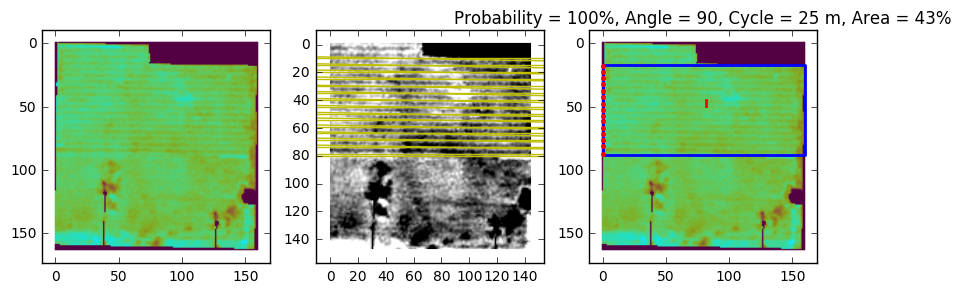

In [389]:
plt.figure(figsize=(10,20))

plt.subplot(131)
plt.imshow(img,cmap=matplotlib.cm.get_cmap('jet'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)

plt.subplot(132)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr[idx_good])
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)

plt.subplot(133)
plt.imshow(img,cmap=matplotlib.cm.get_cmap('jet'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()

plot_box(img,direction,points_cl)

plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)

plt.title('Probability = %i%%, Angle = %.0f, Cycle = %.0f m, Area = %0.f%%' % \
          (np.round(prob*100),np.round(angle_med),np.round(cycle_px*5),np.round(pct_area*100)))

plt.show()

In [390]:
cycle_px

5.0